<a href="https://colab.research.google.com/github/Kshitij09/Forest-Fire-Detection/blob/master/fastai_training_forest_fire_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Gathering and setup

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir -p /root/data/
!mkdir -p /root/.torch/models
!ln -s /root/.torch/models /content
!ln -s /root/data /content
!cp /content/drive/My\ Drive/Forest-Fire-Detection/train.tar.xz /root/data/forest-fire-train.tar.xz
!cp /content/drive/My\ Drive/Forest-Fire-Detection/test.tar.xz /root/data/forest-fire-test.tar.xz
!tar -xf /root/data/forest-fire-train.tar.xz -C /root/data
!tar -xf /root/data/forest-fire-test.tar.xz -C /root/data
!rm -rf data/forest-fire-train.tar.xz data/forest-fire-test.tar.xz

In [0]:
# !rm -rf data/train/.ipynb_checkpoints
# !python3 split_data.py -s data/train -d data/splits -t 0.1
# !mv /root/data/test/ /root/data/valid/
# !rm -rf /root/data/train/
# !mv /root/data/splits/* /root/data
# !rm -rf /root/data/splits

In [0]:
train_dir = Path("/content/data/train")
test_dir = Path("/content/data/test")

In [0]:
#fastai setup
!pip install fastai --upgrade > /dev/null

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

# Looking at the data

In [0]:
bs = 6

In [0]:
# data = ImageDataBunch.from_folder(Path('data/train'), test='data/test',size=256, ds_tfms=get_transforms(), bs=bs)
data = (ImageList.from_folder(Path('data/train')) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(seed=142)              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(get_transforms(), size=256)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

In [0]:
!find /root/data/test -type f | wc -l

93


In [0]:
data = ImageList.from_folder(Path('data/train')).split_none().label_from_folder().transform(get_transforms(), size=256)
val_test = (ImageList.from_folder(Path('data/test'))
                  .split_by_rand_pct(0.3, seed=142)
                  .label_from_folder()
                  .transform(get_transforms(), size=256)
                  .databunch(bs=1))
data.valid = val_test.train_ds
data.test = val_test.valid_ds
data = data.databunch(bs=12)

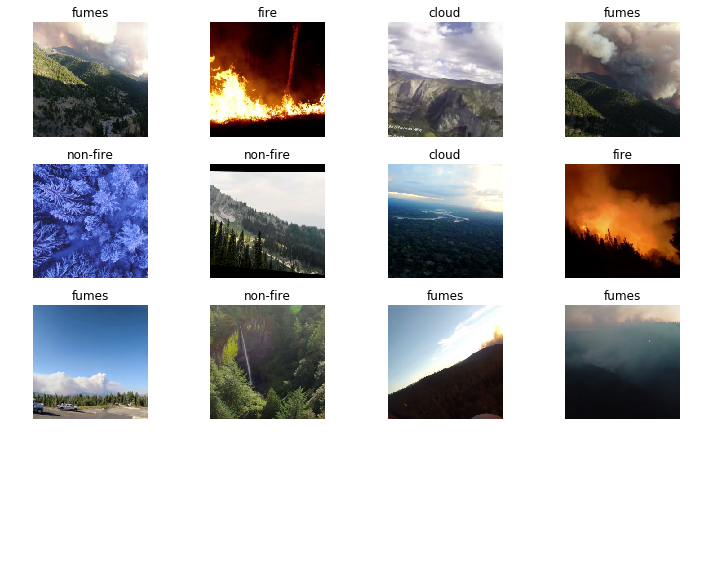

In [0]:
data.show_batch(figsize=(10,8), ds_type=DatasetType.Train)

In [0]:
np.bincount(data.label_list.valid.y.items)

array([15, 15, 17, 19])

# Training

## resnet34

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 88.4MB/s]


In [0]:
learn.summary()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


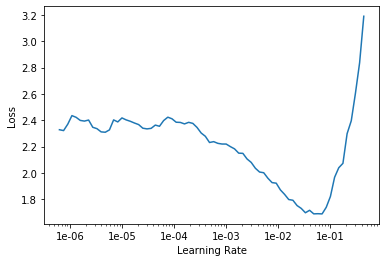

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, 1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.778813,0.439753,0.136364,00:27
1,0.844839,0.491403,0.227273,00:27


In [0]:
learn.save('stage-1-(8)')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

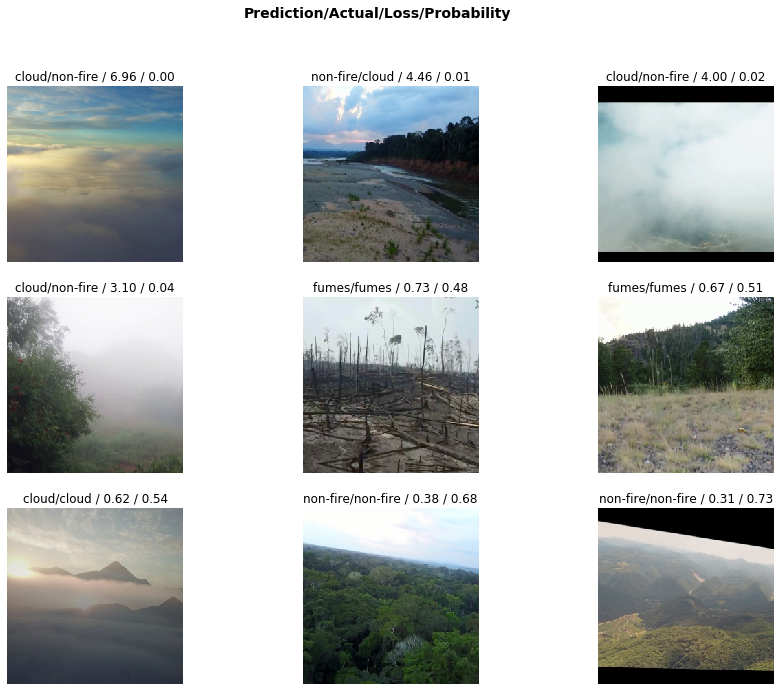

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

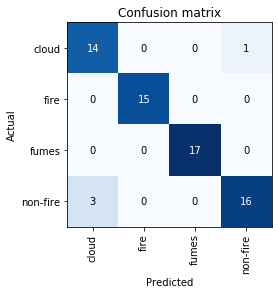

In [0]:
interp.plot_confusion_matrix()

In [0]:
interp.most_confused(2)

[('cloud', 'non-fire', 3), ('non-fire', 'cloud', 3), ('cloud', 'fumes', 2)]

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.999661,0.910852,0.227273,00:27


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


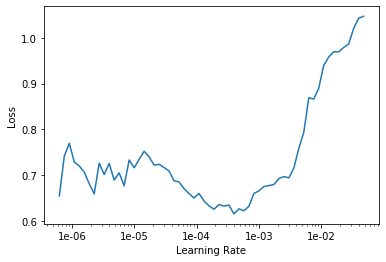

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(5e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.685829,0.620648,0.106061,00:27
1,0.624263,0.281569,0.060606,00:28
2,0.601211,0.483297,0.136364,00:28
3,0.477718,0.523629,0.136364,00:27


In [0]:
learn.save('stage-2-(8)')

In [0]:
preds, targets = learn.get_preds(ds_type=DatasetType.Test)
preds = np.argmax(preds, axis=1)
print((preds==targets).numpy().mean())

0.8888888888888888
